In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from regressors import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
plt.style.use('seaborn') # pretty matplotlib plots
%matplotlib inline

** In this approach I'm going to do manual data cleaning both on the train and test datasets, first load the data and visually inspect the correlation between variables and saleprice **

In [229]:
data_train = pd.read_csv('train.csv')
data_test = pd.read_csv('test.csv')
ntrain = data_train.shape[0]
ntest = data_test.shape[0]
data_all = pd.concat([data_train.drop('SalePrice',axis=1),data_test])

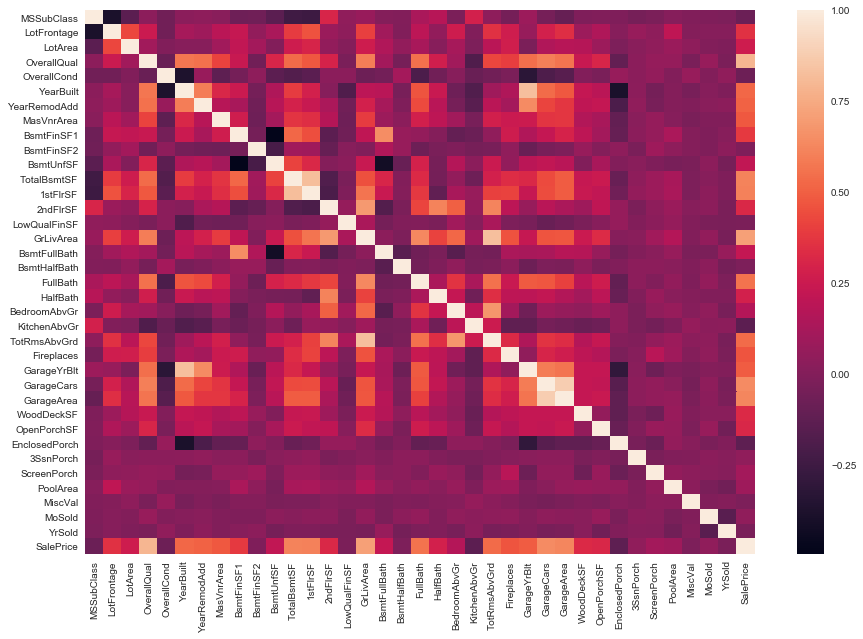

In [104]:
fig, ax = plt.subplots()
fig.set_size_inches(15,10)
sns.heatmap(data_train.drop('Id',axis=1).corr())

In [91]:
data_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 80 columns):
Id               2919 non-null int64
MSSubClass       2919 non-null int64
MSZoning         2915 non-null object
LotFrontage      2433 non-null float64
LotArea          2919 non-null int64
Street           2919 non-null object
Alley            198 non-null object
LotShape         2919 non-null object
LandContour      2919 non-null object
Utilities        2917 non-null object
LotConfig        2919 non-null object
LandSlope        2919 non-null object
Neighborhood     2919 non-null object
Condition1       2919 non-null object
Condition2       2919 non-null object
BldgType         2919 non-null object
HouseStyle       2919 non-null object
OverallQual      2919 non-null int64
OverallCond      2919 non-null int64
YearBuilt        2919 non-null int64
YearRemodAdd     2919 non-null int64
RoofStyle        2919 non-null object
RoofMatl         2919 non-null object
Exterior1st      2918 non-

** There is too much missing data in the Fence, PoolQC, MiscFeature, FireplaceQu, and alley data so I'll just drop them **

In [288]:
data_all_processed = data_all.drop(['Fence','PoolQC', 'MiscFeature', 'Alley', 'FireplaceQu'],axis=1)
data_all_processed = data_all_processed.apply(lambda x: x.fillna(x.median()) if x.dtype != 'object' else x.fillna(x.value_counts().index[0]))
data_all_processed['TSF'] = data_all_processed['1stFlrSF'] + data_all_processed['2ndFlrSF']
data_all_processed.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,TSF
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,0,2,2008,WD,Normal,1710
1,2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,...,0,0,0,0,0,5,2007,WD,Normal,1262
2,3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,...,0,0,0,0,0,9,2008,WD,Normal,1786
3,4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,...,272,0,0,0,0,2,2006,WD,Abnorml,1717
4,5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,...,0,0,0,0,0,12,2008,WD,Normal,2198


In [331]:
data_all_processed.EnclosedPorch.std()/(data_all_processed.EnclosedPorch.max() - data_all_processed.EnclosedPorch.max()

0.21743574534251

In [340]:
data_all_processed.apply(lambda x: ( (x.std()/(x.max()-x.min())) if x.dtype != "object" else x.value_counts().index[0]))

Id                13.5326
MSSubClass        3.85881
MSZoning               RL
LotFrontage       5.91494
LotArea           19.7122
Street               Pave
LotShape              Reg
LandContour           Lvl
Utilities          AllPub
LotConfig          Inside
LandSlope             Gtl
Neighborhood        NAmes
Condition1           Norm
Condition2           Norm
BldgType             1Fam
HouseStyle         1Story
OverallQual       2.05564
OverallCond       2.05564
YearBuilt         14.1906
YearRemodAdd      14.1039
RoofStyle           Gable
RoofMatl          CompShg
Exterior1st       VinylSd
Exterior2nd       VinylSd
MasVnrType           None
MasVnrArea              0
ExterQual              TA
ExterCond              TA
Foundation          PConc
BsmtQual               TA
                   ...   
BsmtFullBath            0
BsmtHalfBath            0
FullBath          1.19432
HalfBath                0
BedroomAbvGr      1.54096
KitchenAbvGr     0.730463
KitchenQual            TA
TotRmsAbvGrd

In [412]:
test = (data_all_processed.select_dtypes(exclude=['object']).apply(lambda x: x.std()/(x.max()-x.min()))>0.15)
test2 = list(test.where(test==True).dropna().index)
data_all_processed_test = data_all_processed[test2]

In [420]:
from scipy.stats import norm, skew
numeric_feats = data_all_processed.dtypes[data_all_processed.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = data_all_processed_test.select_dtypes(exclude=['object']).apply(lambda x: skew(x)).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
ScreenPorch,2.978396
BsmtFinSF2,2.564481
EnclosedPorch,2.025461
MasVnrArea,0.636361
HalfBath,0.590565
BsmtFullBath,0.441864
MSSubClass,0.380477
2ndFlrSF,0.327362
Fireplaces,0.287450
WoodDeckSF,0.222631


In [421]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    #all_data[feat] += 1
    data_all_processed_test[feat] = boxcox1p(data_all_processed_test[feat], lam)

There are 20 skewed numerical features to Box Cox transform


C:\Users\Mehdy\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [422]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC,LinearRegression
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor, BaggingRegressor, AdaBoostRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler,StandardScaler,Normalizer
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import VarianceThreshold
import lightgbm as lgb

In [423]:
train = data_all_processed_test[:ntrain]
test = data_all_processed_test[ntrain:]
train_num = train.select_dtypes(exclude=['object'])
test_num = test.select_dtypes(exclude=['object'])
y_train = np.log1p(data['SalePrice'])

In [424]:
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train_num.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [425]:
linear = make_pipeline(StandardScaler(), LinearRegression(normalize=True))
lasso = make_pipeline(StandardScaler(), Lasso(alpha =0.0005, random_state=1))
ENet = make_pipeline(StandardScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
RFR = RandomForestRegressor(n_estimators=1000)
ADAR = AdaBoostRegressor(learning_rate = 0.5, n_estimators=1000)
#GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                #   max_depth=4, max_features='sqrt',
                                 #  min_samples_leaf=15, min_samples_split=10, 
                                 #  loss='huber', random_state =5)
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

In [ ]:
print(f"Linear score is {rmsle_cv(linear).mean()}")
print(f"Lasso score is {rmsle_cv(lasso).mean()}")
print(f"ElasticNet score is {rmsle_cv(ENet).mean()}")
print(f"Ridge score is {rmsle_cv(KRR).mean()}")
print(f"Random Forest score is {rmsle_cv(RFR).mean()}")
print(f"AdaBoost score is {rmsle_cv(ADAR).mean()}")
#print(f"Gradiant Boost score is {rmsle_cv(GBoost).mean()}")
print(f"lgb score is {rmsle_cv(model_lgb).mean()}")

Linear score is 0.21576240962999355
Lasso score is 0.2157539251276143
ElasticNet score is 0.21575195797082564
Ridge score is 0.21977053373796193


In [307]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)  
    

In [313]:
test = AveragingModels((linear,lasso,ENet,KRR,model_lgb,GBoost,RFR,ADAR))
test2 = StackingAveragedModels(base_models = (linear,ENet),
                                                 meta_model = lasso)

In [314]:
print(f"lgb score is {rmsle_cv(test2).mean()}")

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [316]:
sns.pairplot(train_num)

KeyboardInterrupt: 

C:\Users\Mehdy\Anaconda3\lib\site-packages\matplotlib\axis.py:1045: UserWarning: Unable to find pixel distance along axis for interval padding of ticks; assuming no interval padding needed.
  warnings.warn("Unable to find pixel distance along axis "
C:\Users\Mehdy\Anaconda3\lib\site-packages\matplotlib\axis.py:1035: UserWarning: Unable to find pixel distance along axis for interval padding of ticks; assuming no interval padding needed.
  warnings.warn("Unable to find pixel distance along axis "
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.
